This notebook uses code snippets from the crocodile python examples (https://github.com/SKA-ScienceDataProcessor/crocodile) to perform w-projection convolutional gridding of a set of continuous visibilities, followed by a Fourier Transform the grid to form a Dirty Image.

To run the script you will need:
 - ipython
 - numpy
 - pylab
 - simulated_data.txt (or any other set of visibility data stored as a text file with columns (u, v, w, real(V), imag(V)).
 
The first three of these can be easily obtained using pip. 

To get pip: 

> apt-get install python-pip

To install each library:

>pip install numpy

etc.

The fourth is a text file created by Simulate_uvw.ipynb. This script assumes it is in the working directory. 


Set up python stuff...

In [1]:
%matplotlib inline

In [2]:
import numpy
import matplotlib.pyplot as pl

First we're going to define some user-supplied parameters:

1. The w-increment
2. The kernel over-sampling factor
3. The kernel support size
4. The kernel far-field size 

In [3]:
wstep=2000
over_sampling=4
ff_size=256
kernel_support=15

Then we're going to get some visibility data. You can create these data using the Simulate_uvw.ipynb notebook.

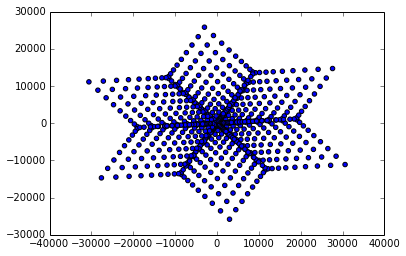

Range of w-values: -14635.0  -  25809.0  lambda


In [4]:
u,v,w,vis_re,vis_im = numpy.loadtxt('./simulated_data.txt',unpack=True)
vis = vis_re + 1j*vis_im
uvw = numpy.column_stack((u,v,w))

# conjugate symmetry
tmp_uvw = uvw*numpy.array([-1.,-1.,1.])
tmp_vis = vis_re - 1j*vis_im

vis = numpy.hstack((vis,tmp_vis))
uvw = numpy.vstack((uvw,tmp_uvw))

pl.subplot(111)
pl.scatter(uvw[:,0],uvw[:,1])
pl.show()
print "Range of w-values:",numpy.amin(uvw[:,2])," - ",numpy.amax(uvw[:,2])," lambda"

Image parameters are defined in terms of the half-width of the FOV, T2, and the half-width of the uv-plane, L2, which is used as an approximation to the angular resolution. 

The number of pixels on the side of an image is 

$$N_{\rm pix} = \frac{\Theta_{\rm FOV}} {\theta_{\rm res}}.$$

Therefore the number of pixels along a side is given by 

$$N_{\rm pix} = 2 T_{1/2}\times 2 L_{1/2}.$$

In [5]:
T2 = 0.001  # half-width of FOV [radians]
L2 = 40000 # half-width of uv-plane [lambda]
N = int(T2*L2*4) # number of pixels 
print "Making grids of side: ",N," pixels."

Making grids of side:  160  pixels.


Create an empty grid to grid visibilities onto, as well as a grid for weights to make the synthesized beam:

In [6]:
grid_uv=numpy.zeros([N, N], dtype=complex)
grid_wt=numpy.zeros([N, N], dtype=complex)

Sort the uvw and visibility data by w:

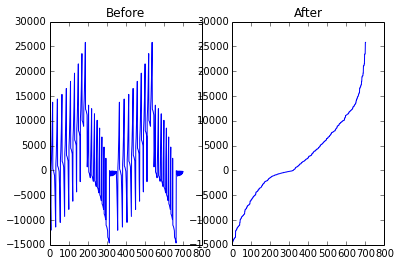

In [7]:
temp=uvw
zs=numpy.argsort(uvw[:,2])
uvw = uvw[zs]
vis = vis[zs]

pl.subplot(121)
pl.plot(temp[:,2])
pl.title("Before")
pl.subplot(122)
pl.plot(uvw[:,2])
pl.title("After")
pl.show()

Then create an array of w-planes spanning the range of w -values in the data:

In [8]:
ii=range(0, len(vis), wstep) # Bojan, is this what you mean here? Every 2000 entries or every 2000 lambda..?

Create a list of boundaries in w-value for each plane:

In [9]:
ir=zip(ii[:-1], ii[1:]) + [(ii[-1], len(vis))]

Each set of limits constitutes a w-plane. With the limits:

In [10]:
ilow,ihigh=ir[0]

For each plane we need to calculate the mean w-value in the uvw-data:

In [11]:
w=uvw[ilow:ihigh,2].mean()

We then need to caluclate the w-kernel for this w-value. First we create a grid for the kernel with values

$$r^2 = \ell^2 + m^2$$

In [12]:
ff = T2*numpy.mgrid[-1:(1.0*(ff_size-2)/ff_size):(ff_size*1j),-1:(1.0*(ff_size-2)/ff_size):(ff_size*1j)]
r2 = (ff**2).sum(axis=0)

Then calculate the value of the kernel at each point, 

$$G(\ell,m,w) = {\rm e}^{-2\pi i  \left[w( \sqrt{1-\ell^2-m^2} - 1 )\right] } $$

(Eq. 11; Cornwell+ 2008 http://arxiv.org/pdf/0807.4161v1.pdf )

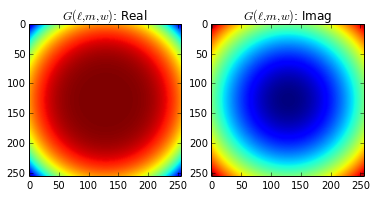

In [13]:
ph=w*(1.-numpy.sqrt(1.-r2)) 
cp=(numpy.exp(2j*numpy.pi*ph))

pl.subplot(121)
pl.imshow(cp.real)
pl.title(r"$G(\ell,m,w)$: Real")
pl.subplot(122)
pl.imshow(cp.imag)
pl.title(r"$G(\ell,m,w)$: Imag")
pl.show()

We need to pad this and FFT it in order to over-sample it in uvw-space to obtain the kernel:

$$ \tilde{G}(u,v,w) = \frac{i}{w}{\rm e}^{ \pi i \left[ \frac{u^2 +v^2}{w} \right] } $$

(Eq. 14; Cornwell+ 2008 http://arxiv.org/pdf/0807.4161v1.pdf )


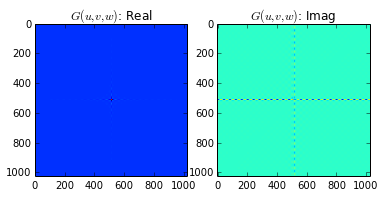

In [14]:
padff=numpy.pad(cp, 
    pad_width=(ff_size*(over_sampling-1.)/2.,),
    mode='constant',
    constant_values=(0.0,))
af=numpy.fft.fftshift(numpy.fft.ifft2(numpy.fft.ifftshift(padff)))

pl.subplot(121)
pl.imshow(af.real)
pl.title(r"$G(u,v,w)$: Real")
pl.subplot(122)
pl.imshow(af.imag)
pl.title(r"$G(u,v,w)$: Imag")
pl.show()

Then just extract the central region with size equal to the kernel support. I've added a couple of options for this: (1) from crocodile; (2) adapted from ASKAPsoft.

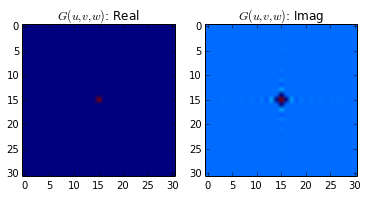

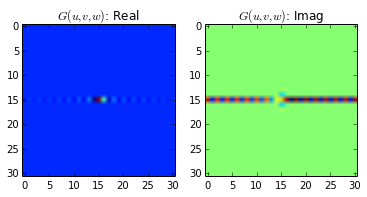

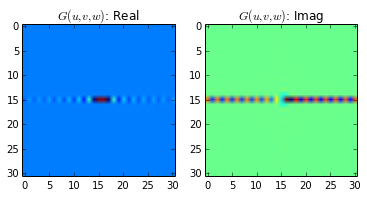

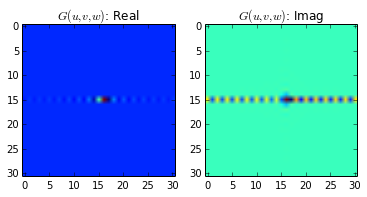

In [15]:
def exmid2(a, s):
    """Extract a section from middle of a map, suitable for zero frequencies at N/2"""
    cx=a.shape[0]/2
    cy=a.shape[1]/2
    return a[cx-s-1:cx+s, cy-s-1:cy+s]

# works in the opposite sense to ASKAPsoft, which calculates an under-sampled kernel and 
# interpolates.
def wextract(a, i, j, Qpx, s):
    """Extract the (ith,jth) w-kernel from the oversampled parent and normalise
    The kernel is reversed in order to make the suitable for
    correcting the fractional coordinates
    """
    x=a[i::Qpx, j::Qpx] # decimate the kernel
    x=x[::-1,::-1] # reverse the kernel
    x*=1.0/x.sum() # normalise the kernel
    
    return exmid2(x,s)


def askapsoft_decimate_n_extract(af, over_sampling, kernel_support):
    
    """
    Extracted and translated from
    AWProjectVisGridder.cc
    """
    
    # why is this normalization required..?
    rescale = over_sampling*over_sampling
            
    cSize = 2 * kernel_support + 1
    itsConvFunc=numpy.zeros((over_sampling, over_sampling, cSize, cSize), dtype=complex)
            
    for fracu in range(0,over_sampling):
        for fracv in range(0,over_sampling):
            
            # Now cut out the inner part of the convolution function and
            # insert it into the convolution function
            for iy in range(-kernel_support,kernel_support+1):
                for ix in range(-kernel_support,kernel_support+1):
                    
                    nx = af.shape[0]
                    ny = af.shape[1]
                    
                    # assumes support is the same for all w-planes:
                    xval = (ix) * over_sampling + fracu + nx / 2
                    yval = (iy) * over_sampling + fracv + ny / 2
                    
                    itsConvFunc[fracu, fracv, ix+cSize/2, iy+cSize/2] \
                            = rescale * af[xval, yval]
                        
    return itsConvFunc

# --------------------------
# --------------------------
# Option (1):
wg=[[wextract(af, i, j, over_sampling, kernel_support) for i in range(over_sampling)] for j in range(over_sampling)]
# Convert list to numpy array:
wg = numpy.array(wg)
# --------------------------
# Option (2):
#wg = askapsoft_decimate_n_extract(af, over_sampling, kernel_support)
# --------------------------


for fracu in range(0,over_sampling):
    pl.subplot(121)
    pl.imshow(wg[fracu,0,:,:].real)
    pl.title(r"$G(u,v,w)$: Real")
    pl.subplot(122)
    pl.imshow(wg[fracu,0,:,:].imag)
    pl.title(r"$G(u,v,w)$: Imag")
    pl.show()


Take the complex conjugate,

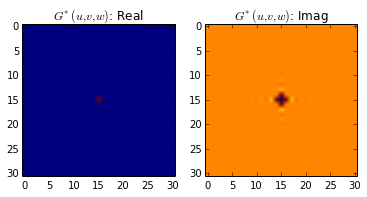

In [16]:
wg = numpy.conj(wg)

pl.subplot(121)
pl.imshow(wg[0,0,:,:].real)
pl.title(r"$G^{\ast}(u,v,w)$: Real")
pl.subplot(122)
pl.imshow(wg[0,0,:,:].imag)
pl.title(r"$G^{\ast}(u,v,w)$: Imag")
pl.show()

Now we have our convolution kernel, we need to find out where we should grid our visibility data.

In [17]:
def fraccoord(N, p, Qpx):
    """Compute whole and fractional parts of coordinates, rounded to Qpx-th fraction of pixel size
    :param N: Number of pixels in total 
    :param p: coordinates in range -1,1
    :param Qpx: Fractional values to round to
    """
    H=N/2
    x=(1+p)*H
    flx=numpy.floor(x + 0.5 /Qpx)
    fracx=numpy.around(((x-flx)*Qpx))    
    return (flx).astype(int), fracx.astype(int)

uvw_sub = uvw[ilow:ihigh,:]/L2 # extract subarray for w-slice
(x, xf), (y, yf) = [fraccoord(grid_uv.shape[i], uvw_sub[:,i], over_sampling) for i in [0,1]]

Then we can convolve the data onto the grid:

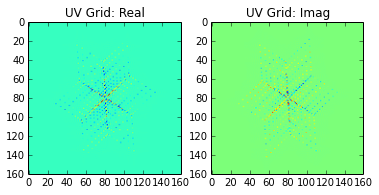

In [18]:
def convgridone(a, pi, fi, gcf, v):
    """Convolve and grid one visibility sample"""
    sx, sy= gcf[0][0].shape[0]/2, gcf[0][0].shape[1]/2
    
    # NB the order of fi below 
    a[ pi[0]-sx: pi[0]+sx+1,  pi[1]-sy: pi[1]+sy+1 ] += gcf[fi[1],fi[0]]*v  
    return a

def gridone(a,p,v):
    """grid one visibility without convolution"""
    
    a[p[0],p[1]] += v
    
    return a

vis_sub = vis[ilow:ihigh]
for i in range(len(x)):
#    gridone(grid_uv, (x[i],y[i]), vis_sub[i])
    convgridone(grid_uv,(x[i], y[i]), (xf[i], yf[i]), wg, vis_sub[i])
    convgridone(grid_wt,(x[i], y[i]), (xf[i], yf[i]), wg, 1.0+0j)
    
pl.subplot(121)
pl.imshow(grid_uv.real)
pl.title("UV Grid: Real")
pl.subplot(122)
pl.imshow(grid_uv.imag)
pl.title("UV Grid: Imag")
pl.show()

Let's FT this grid to check it gives a sensible map...

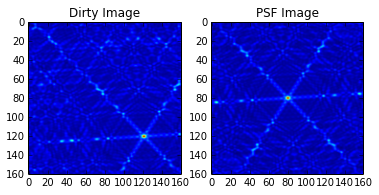

In [19]:
dty_image=numpy.fft.fftshift(numpy.fft.ifft2(numpy.fft.ifftshift(grid_uv)))
psf_image=numpy.fft.fftshift(numpy.fft.ifft2(numpy.fft.ifftshift(grid_wt)))

pl.subplot(121)
pl.imshow(dty_image.real)
pl.title("Dirty Image")
pl.subplot(122)
pl.imshow(psf_image.real)
pl.title("PSF Image")
pl.show()

Done!